# I. DATA PREPARATION

In [14]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [15]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
df_dlr = pd.read_csv('https://www.dropbox.com/scl/fi/xkf9ttbop2wyypp8bttgw/NBT19MTT2b_od__DLR_tb_wf.csv?rlkey=me22ozynt7i13ah9hvh9f157m&dl=1')
df_ezl = pd.read_csv('https://www.dropbox.com/scl/fi/vizzmmz5u1mhhxignbwei/NBT19MTT2b_od__EZL_tb_wf.csv?rlkey=nz69dj4n7x02389gl7gc95knw&dl=1')
df_lo = pd.read_csv('https://www.dropbox.com/scl/fi/rhofj793lzlh6ptheo0ui/NBT19MTT2b_od__LO_tb_wf.csv?rlkey=btj1o5i02dx9paqhpkhk1chlo&dl=1')
df_lu = pd.read_csv('https://www.dropbox.com/scl/fi/572yutkebg3pa4pjn42d9/NBT19MTT2b_od__LU_tb_wf.csv?rlkey=0rfklc4u7nxcwbtsjsko0i3xd&dl=1')

files = [df_dlr, df_ezl, df_lo, df_lu]
london_OD = pd.concat(files, ignore_index=True)

In [16]:
london_OD

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.03300,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.71900,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.94100,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.79500,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.78600,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
62575,884,784,97.99600,538.180,298.849,173.856,51.263,14.653,LU,0.0,0.0
62576,884,787,115.91900,281.952,149.409,138.607,64.885,25.433,LU,0.0,0.0
62577,884,788,139.04400,682.340,768.051,504.189,345.944,113.663,LU,0.0,0.0
62578,884,789,156.23601,481.302,702.600,595.686,317.113,63.273,LU,0.0,0.0


In [17]:
definition_df = pd.read_excel('https://www.dropbox.com/scl/fi/8rvd82qd4ald2yyt2bz6m/NBT19_Definitions.xlsx?rlkey=5jcia5kufnlmictzcs9nc2qia&dl=1', 'Stations')

In [18]:
definition_df

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True
...,...,...,...,...
732,9445.0,BCJt,Beckenham Junction Trams,True
733,9460.0,CSTt,Church Street,True
734,9471.0,ELMt,Elmers End,True
735,9473.0,GSTt,George Street,True


In [19]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)

In [20]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])

In [21]:
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [22]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()

In [23]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)

In [24]:
london_OD_AMpeak

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113
...,...,...,...
62575,Canning Town,Southwark,538
62576,Canning Town,Bermondsey,281
62577,Canning Town,Canada Water,682
62578,Canning Town,North Greenwich,481


In [25]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [26]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

In [27]:
london_OD_AMpeak

,station_origin,station_destination,flows
0,Stratford International,King George V,16
1,Stratford International,London City Airport,40
2,Stratford International,Pontoon Dock,17
3,Stratford International,West Silvertown,26
4,Stratford International,Woolwich Arsenal,113
...,...,...,...
62575,Canning Town,Southwark,538
62576,Canning Town,Bermondsey,281
62577,Canning Town,Canada Water,682
62578,Canning Town,North Greenwich,481


In [28]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [29]:
london_OD_AMpeak

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0
1,Abbey Road,Beckton,1
2,Abbey Road,Blackwall,3
3,Abbey Road,Canary Wharf,1
4,Abbey Road,Canning Town,37
...,...,...,...
61523,Woolwich Arsenal,Tower Gateway,127
61524,Woolwich Arsenal,West Ham,608
61525,Woolwich Arsenal,West India Quay,6
61526,Woolwich Arsenal,West Silvertown,81


In [30]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()

### Load London Underground shapefile data

In [31]:
#read in the data using geopandas
stations = gpd.read_file('https://www.dropbox.com/scl/fi/j1ugr3bsub9jhp8b0btkq/tfl_stations.json?rlkey=r38t2xn9n5erc1y3jzub6tqol&dl=1')
lines = gpd.read_file('https://www.dropbox.com/scl/fi/ov98qi02qju6kcq5vxnbb/tfl_lines.json?rlkey=h9wip7f1drqn4prgf0fhkcvna&dl=1')

In [32]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [33]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

#stations[['name','id']].groupby('name').count().sort_values(by='id',ascending=False)

**Change position of station to mean of all station with the same name**

In [34]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [35]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

### Lines file

In [36]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))

In [37]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [38]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

## Create seperate graphs for each line and then join

Since we don't have properly constructed line geometries because:
* there are discontinuities in the line geometries
* a line between two stations can actually be composed of more than one geometry

We will construct geometric graphs (meaning graphs just from the line geometries where nodes are coordinates that define the line geometry). It's easy to fix the discontinuities in this manner because the can be thought of as nodes with degree = 1 that have another node with degree = 1 within a threshold distance. 

Once we have these discontinuties fixed we can use these geometric graphs to construct proper geometries between stations by taking the shortest paths within these networks starting from the node closest to the origin station and ending in the node closest to the destination station. The shortest path will then be a list of coordinates that define the line geometry between the two stations. 

London Overground


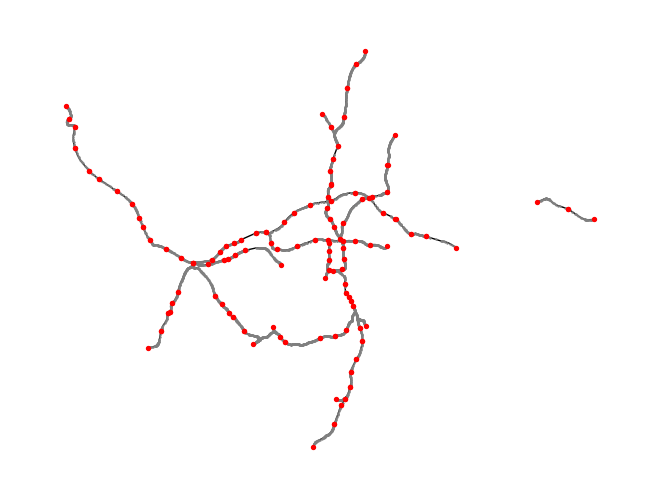

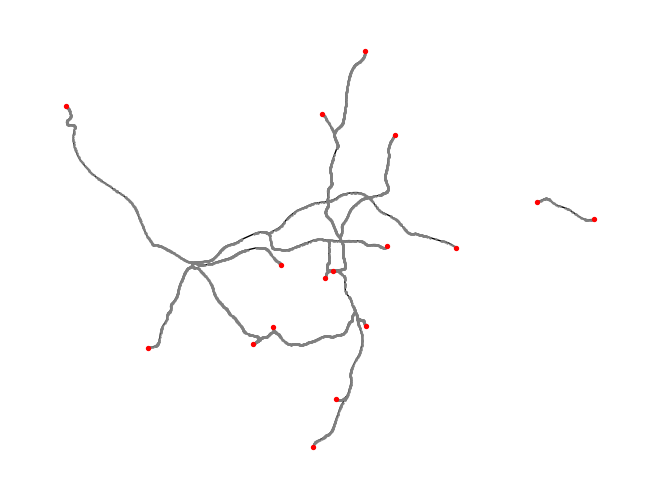

3
DLR


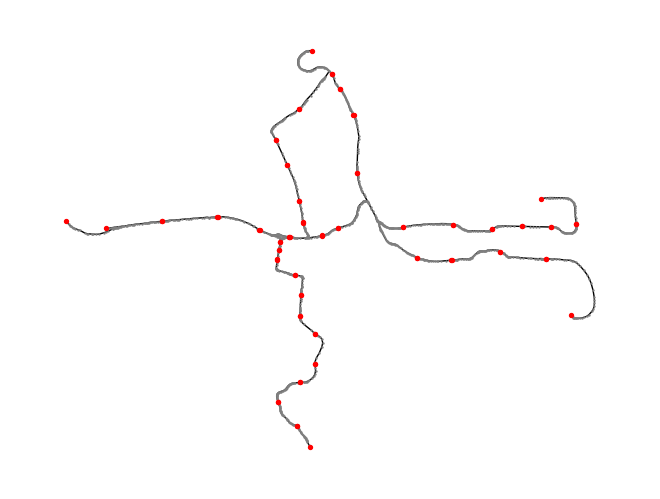

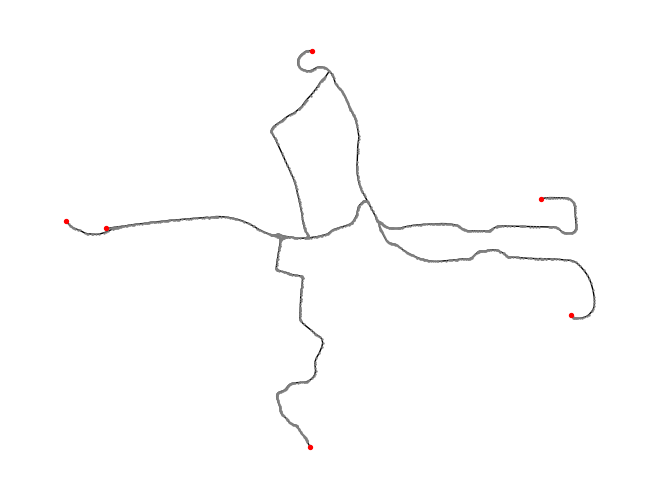

1
Jubilee


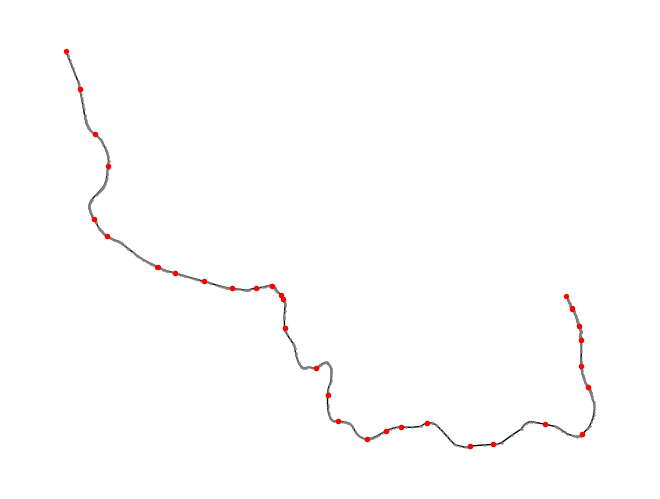

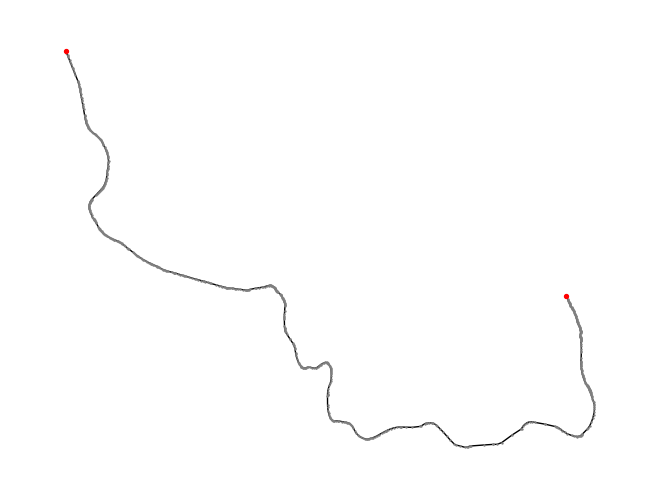

1
Metropolitan


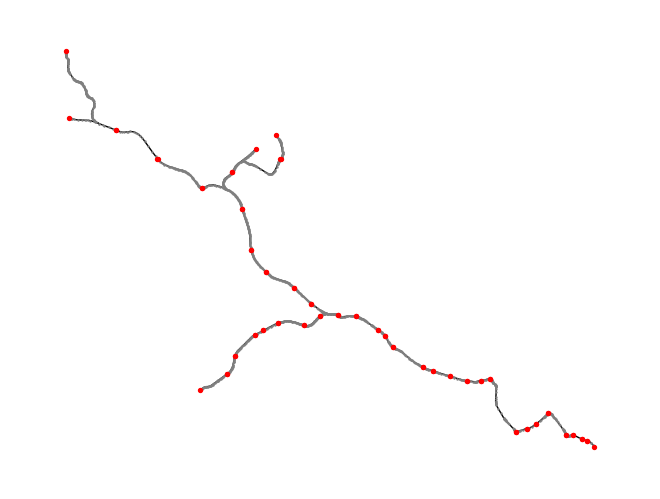

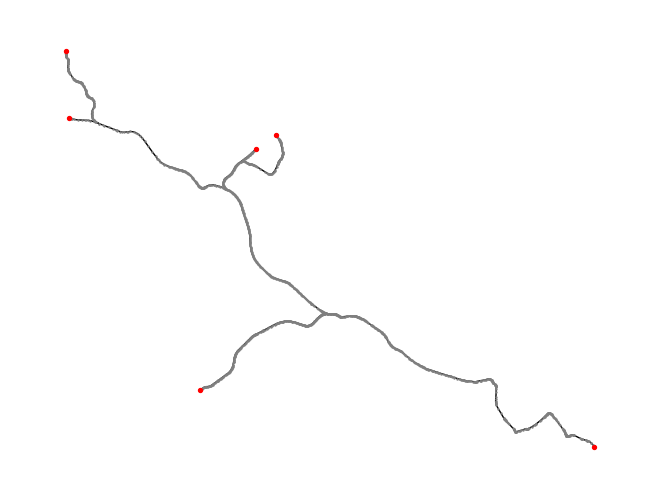

1
Circle


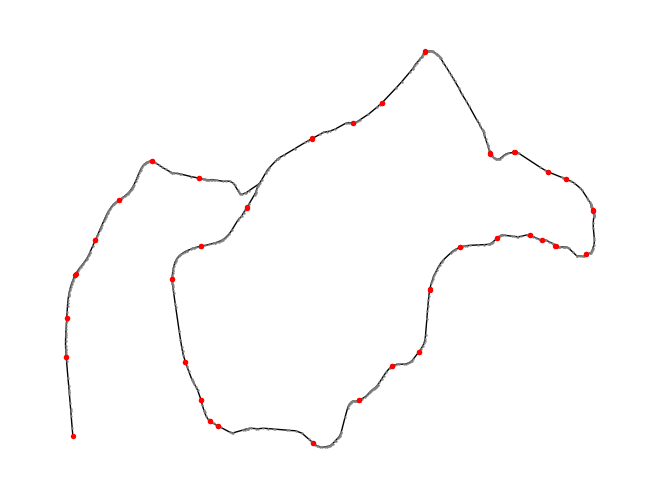

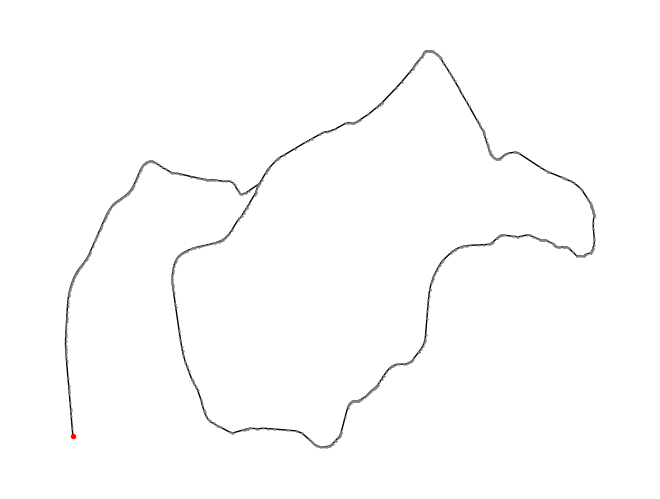

1
Hammersmith & City


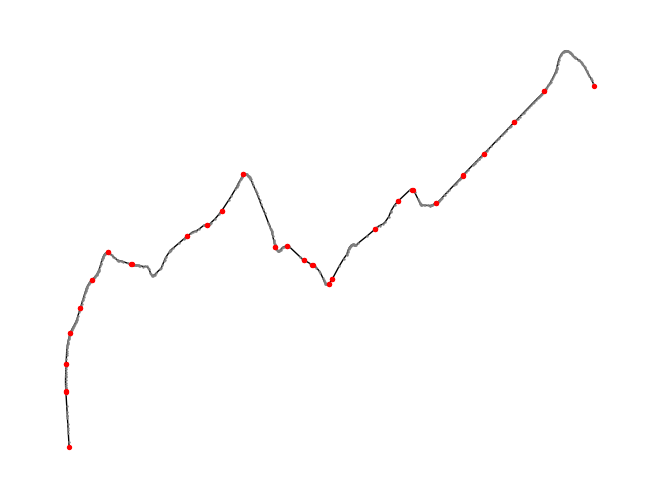

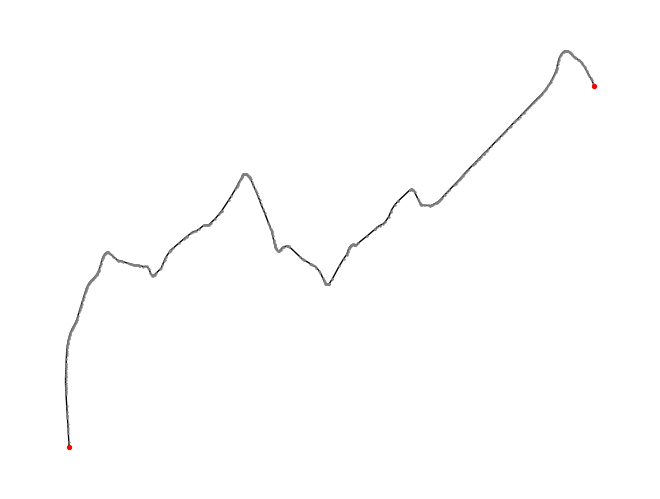

1
District


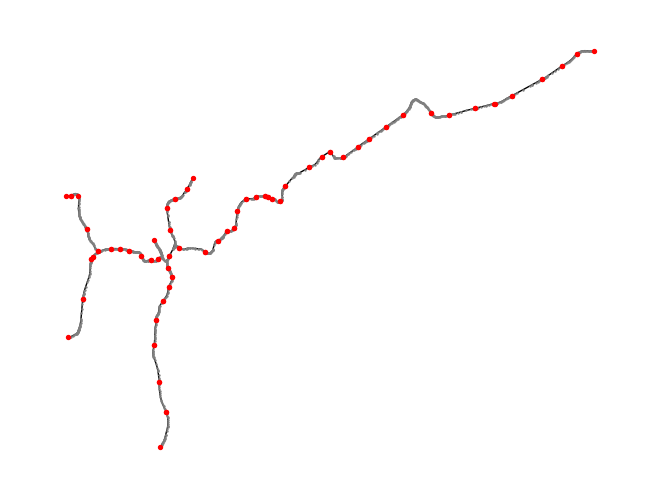

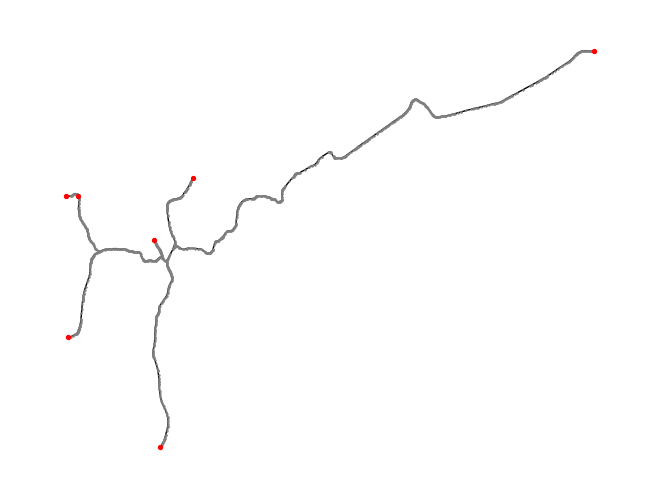

1
Piccadilly


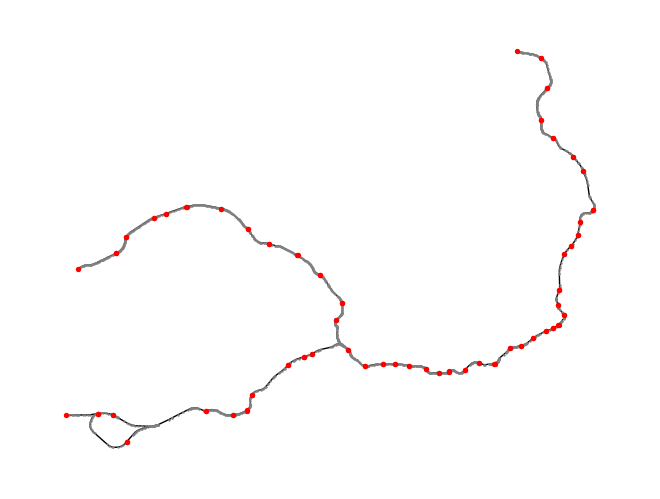

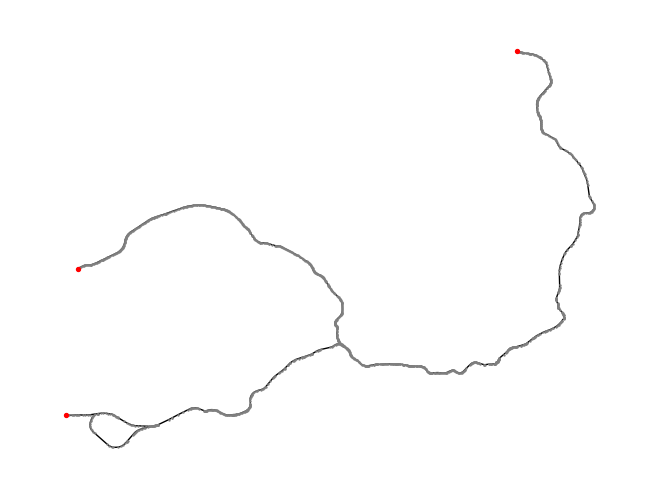

1
Central


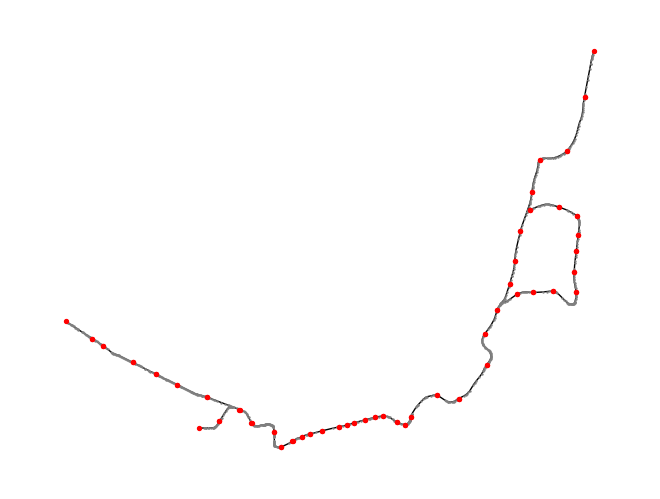

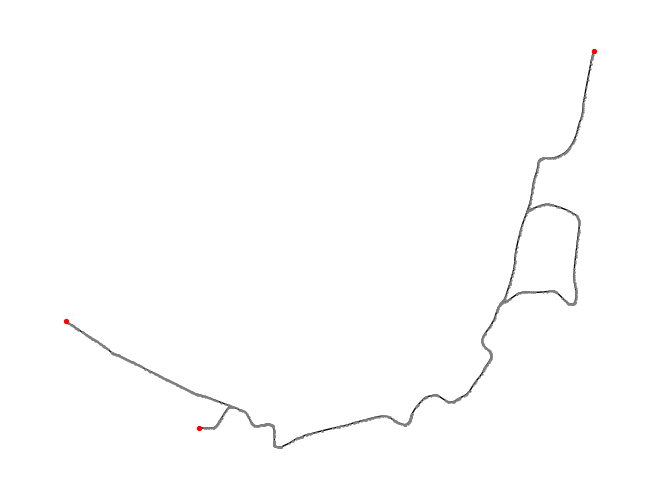

1
Bakerloo


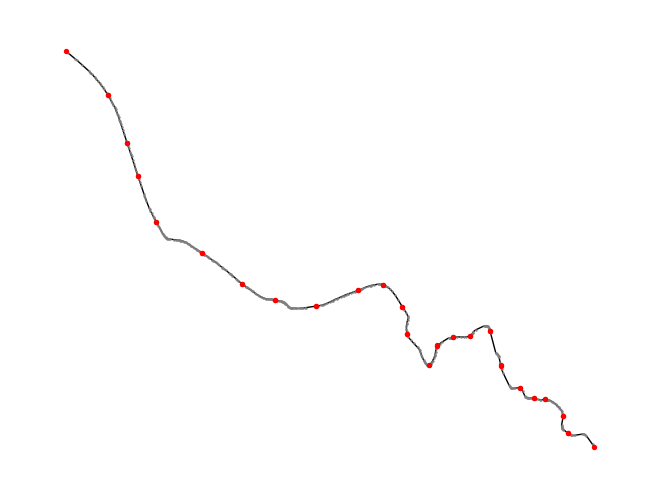

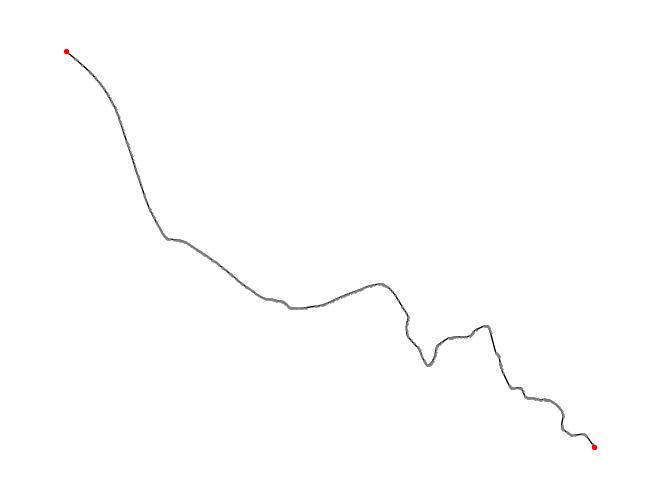

1
Waterloo & City


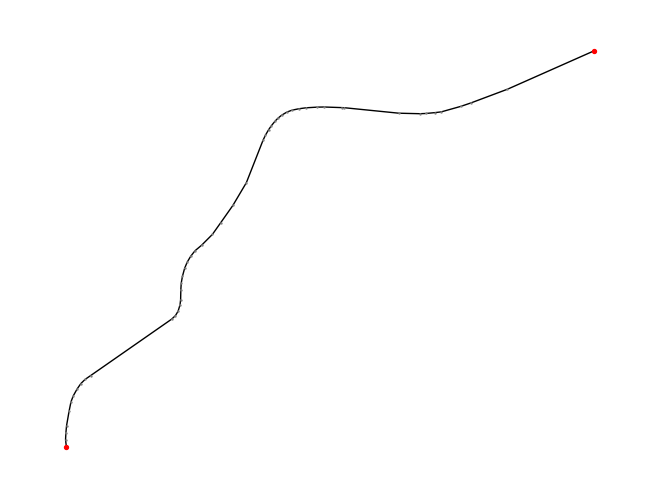

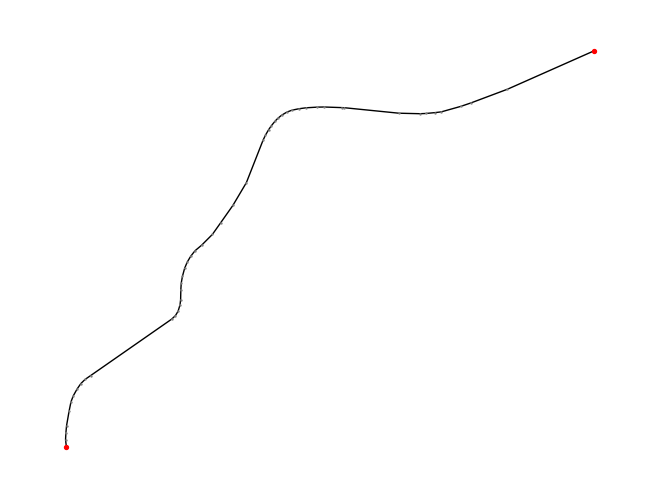

1
TfL Rail


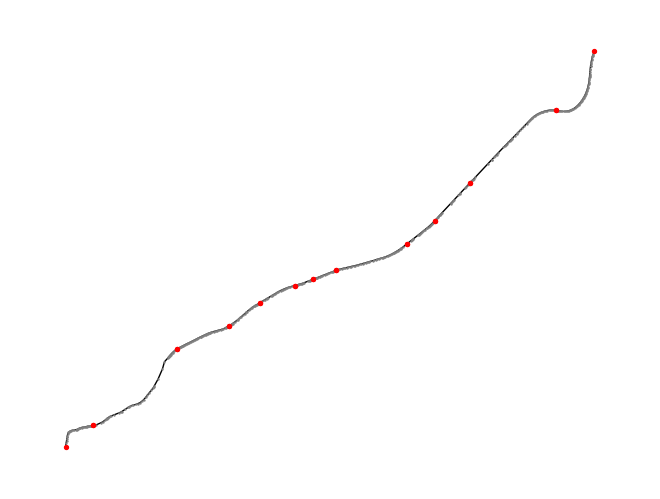

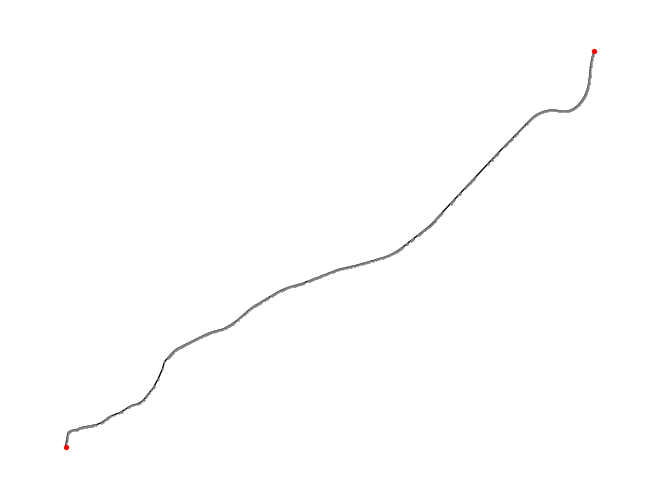

1
Victoria


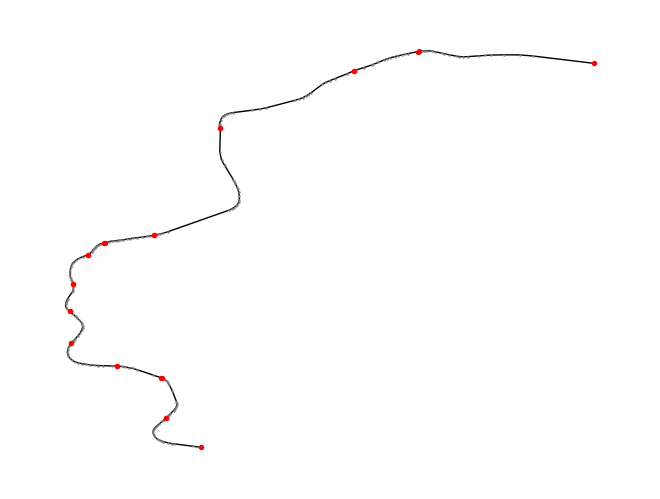

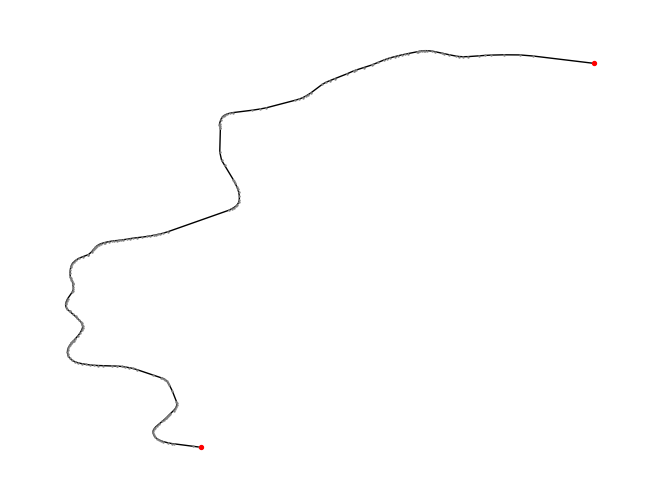

1
Northern


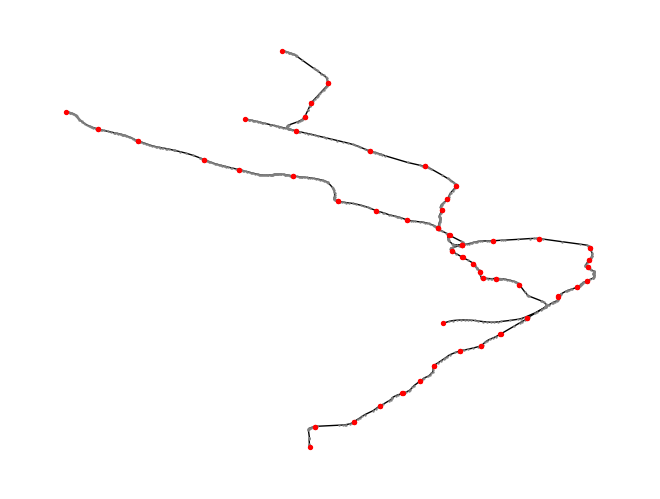

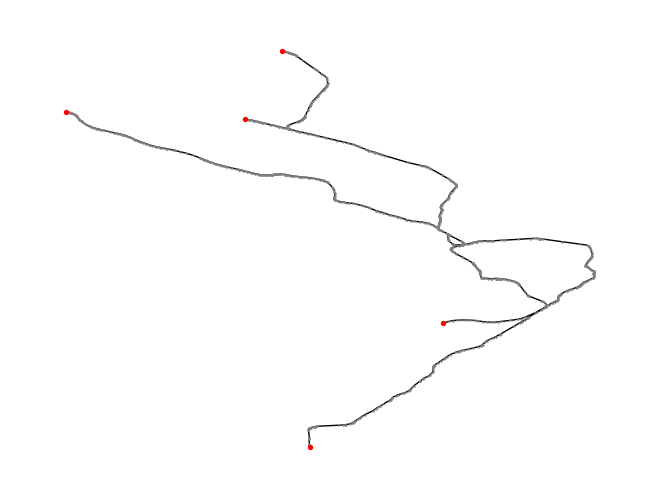

1


In [39]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Now that we have these geometric graphs we can create our final graph by using the data in the lines attribute in our lines geodataframe that contains origin and destination station. We can then use our geometric graph and find the shortest route to create our line geometries and find the length of the lines. 

We will store this information in a dataframe that we can use to create our final graph

In [40]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

In [41]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs

In [42]:
edge_gdf

,line_name,start_id,end_id,geometry
0,London Overground,910GCAMHTH,910GBTHNLGR,"LINESTRING (534826.877 183290.997, 534856.070 ..."
1,London Overground,910GCAMHTH,910GLONFLDS,"LINESTRING (534826.877 183290.997, 534782.941 ..."
2,London Overground,910GLONFLDS,910GHAKNYNM,"LINESTRING (534782.941 184260.470, 534531.043 ..."
3,London Overground,910GHAKNYNM,910GRCTRYRD,"LINESTRING (534531.043 185134.568, 533997.280 ..."
4,London Overground,910GRCTRYRD,910GSTKNWNG,"LINESTRING (533997.280 186185.005, 533682.473 ..."
...,...,...,...,...
631,Northern,940GZZLUTCR,940GZZLULSQ,"LINESTRING (529781.482 181328.939, 529970.022 ..."
632,Northern,940GZZLULSQ,940GZZLUCHX,"LINESTRING (529970.022 180803.970, 530059.341 ..."
633,Northern,940GZZLUWLO,940GZZLUKNG,"LINESTRING (530974.091 179921.099, 531626.075 ..."
634,Northern,940GZZLU991,940GZZLU990,"LINESTRING (529053.258 177243.076, 530049.490 ..."


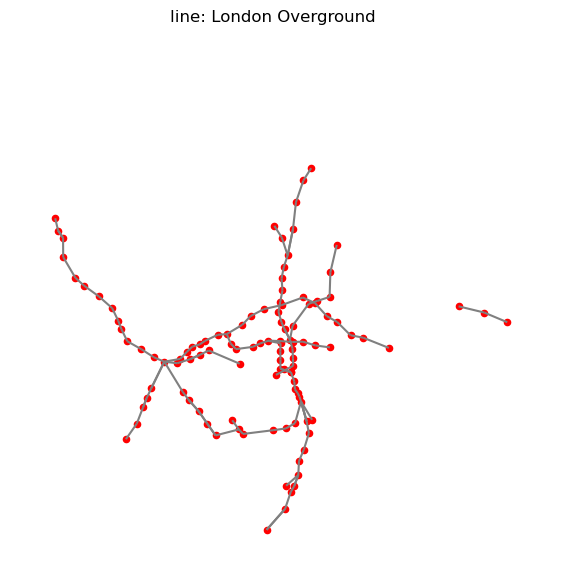

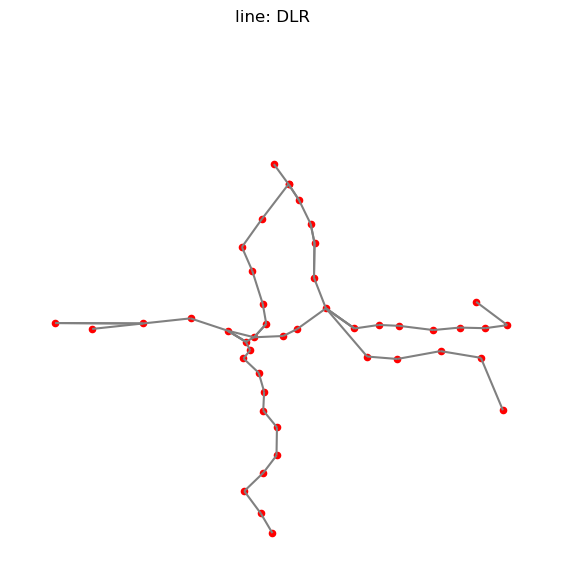

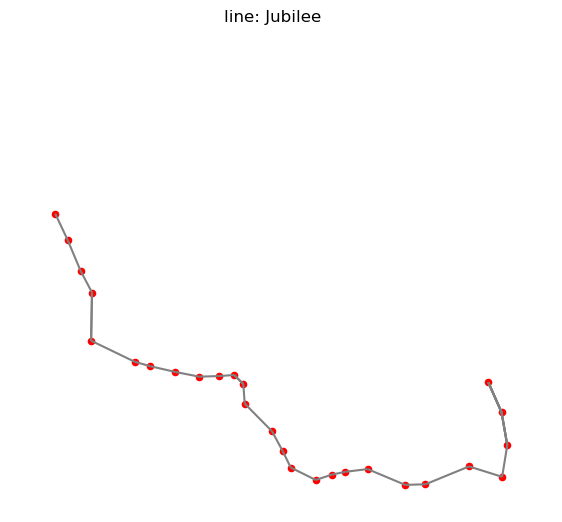

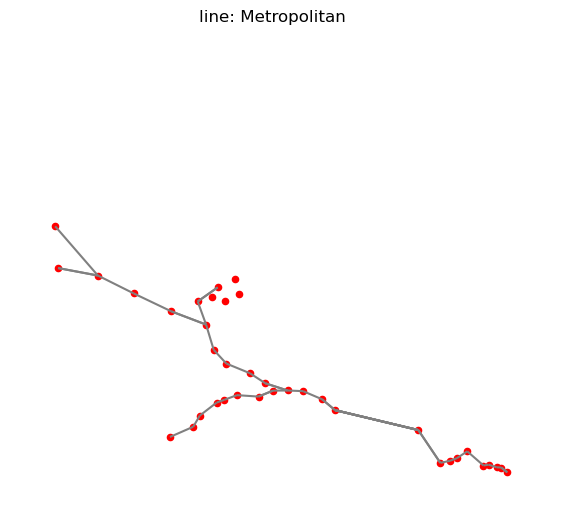

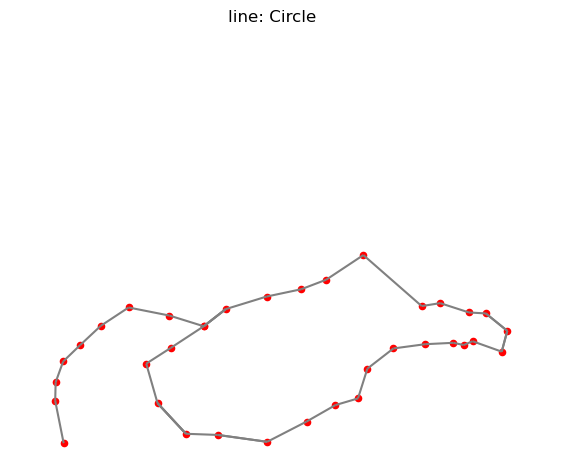

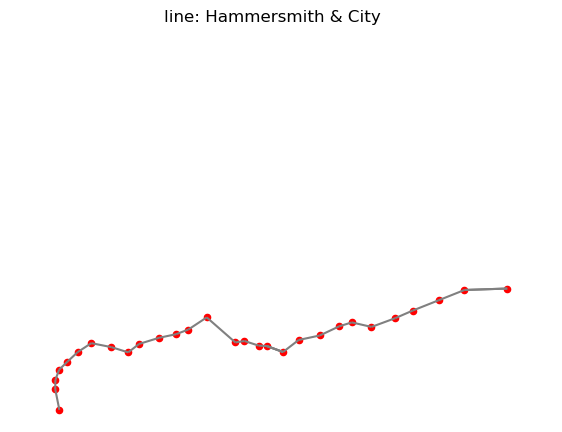

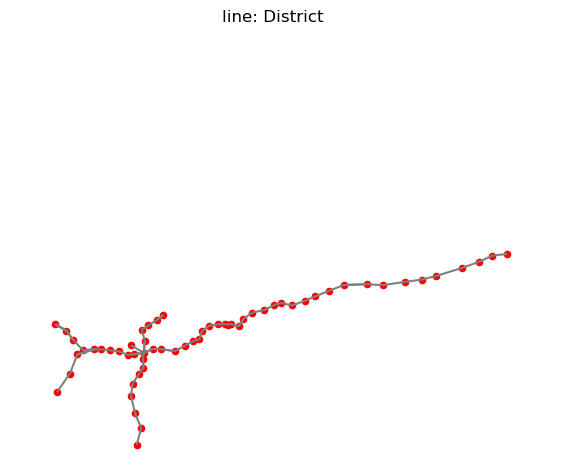

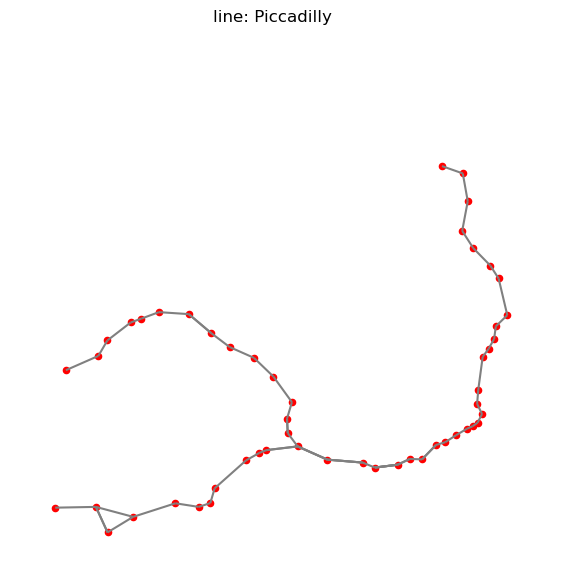

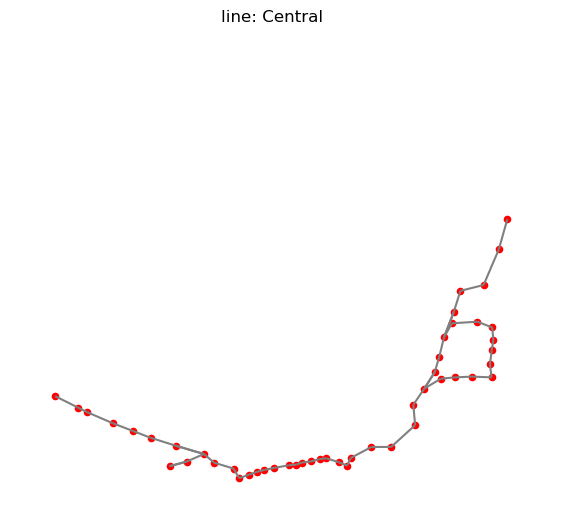

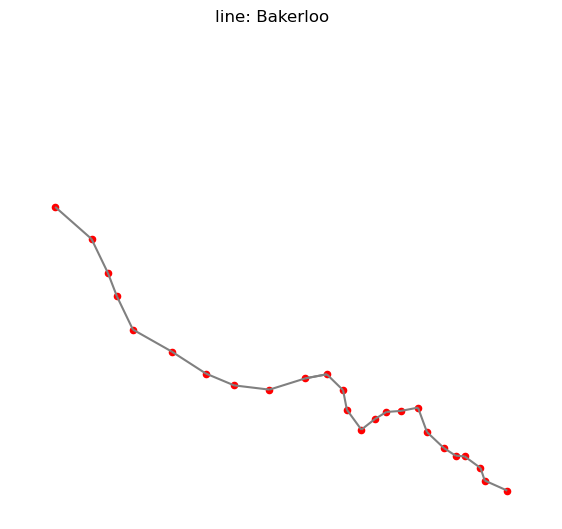

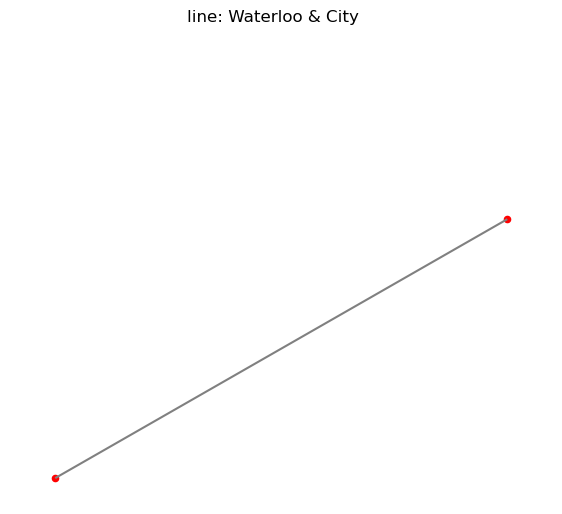

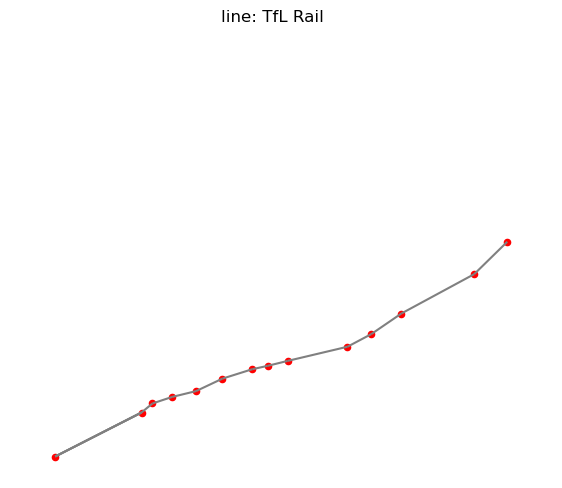

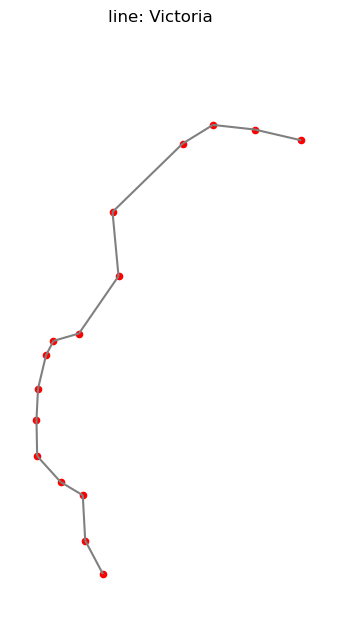

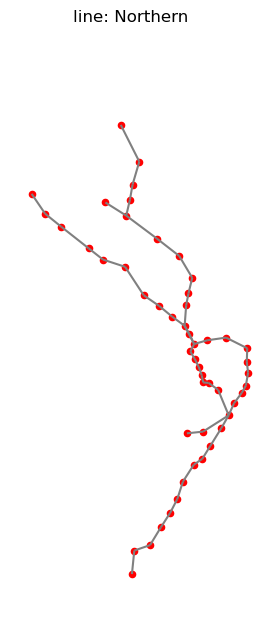

In [43]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

In [44]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [45]:
edge_gdf.head(2)

,line_name,start_id,end_id,geometry,length
0,London Overground,910GCAMHTH,910GBTHNLGR,"LINESTRING (534826.877 183290.997, 534827.512 ...",831.871588
1,London Overground,910GCAMHTH,910GLONFLDS,"LINESTRING (534826.877 183290.997, 534827.512 ...",979.416986


<Axes: >

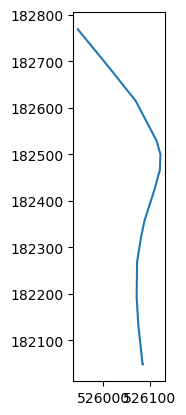

In [46]:
edge_gdf.sample(1).plot()

In [47]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [48]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [75]:
edge_gdf

,line_name,start_id,end_id,geometry,length
0,London Overground,Cambridge Heath,Bethnal Green,"LINESTRING (534826.877 183290.997, 534827.512 ...",831.871588
1,London Overground,Cambridge Heath,London Fields,"LINESTRING (534826.877 183290.997, 534827.512 ...",979.416986
2,London Overground,London Fields,Hackney Downs,"LINESTRING (534782.941 184260.470, 534782.678 ...",926.012712
3,London Overground,Hackney Downs,Rectory Road,"LINESTRING (534531.043 185134.568, 534531.871 ...",1201.022377
4,London Overground,Rectory Road,Stoke Newington,"LINESTRING (533997.280 186185.005, 533998.001 ...",783.255714
...,...,...,...,...,...
631,Northern,Tottenham Court Road,Leicester Square,"LINESTRING (529781.482 181328.939, 529830.781 ...",585.940371
632,Northern,Leicester Square,Charing Cross,"LINESTRING (529970.022 180803.970, 529970.059 ...",462.074817
633,Northern,Waterloo,Kennington,"LINESTRING (530974.091 179921.099, 530974.644 ...",1760.198517
634,Northern,Battersea Power Station,Nine Elms,"LINESTRING (529053.258 177243.076, 529053.258 ...",1073.465362


## IMPORTANT!!!

{'TfL Rail', 'Piccadilly', 'Northern', 'Metropolitan', 'Circle', 'Victoria', 'London Overground', 'Central', 'Hammersmith & City', 'Bakerloo', 'DLR', 'District', 'Waterloo & City', 'Jubilee'}


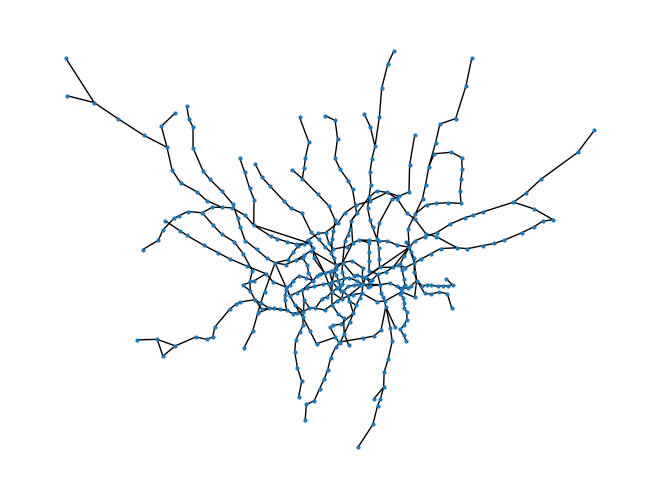

In [49]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

#save position to graph
nx.set_node_attributes(G, pos, 'coords')

### Sanity check our network

In [50]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [51]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496486, 'line_name': 'Metropolitan'})

In [52]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Bond Street', 'Baker Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Edgware Road'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park")]

In [53]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [54]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [55]:
df.sort_values('degree', ascending = False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Liverpool Street,6
West Ham,6
Canning Town,6
Oxford Circus,6
Green Park,6
Earl's Court,6


### Merge Network with OD data

ok, we are almost done!

We have processed our raw data, now we need to combine the two (TLF OD and our Network). For this we need two types of merge:

1. add flows as weights to the network (to be able to calculate disruptions to the network)
2. create OD with distance for our spatial interaction models (for our spatial interaction models)

In [56]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [57]:
OD_names

{'Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green',
 'Blackfriars',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf',
 'Canning Town',
 'Cannon Street',
 'Canonbury',
 'Canons Park',
 'Carpenders Park',
 'Chadwell He

Ok, we have a few stations that don't match up. They are small enough that we can solve this quickly by creating a mapping between names of the stations that we can keep.

* Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.
* Action Main Line, Hanwell, Hayes & Harlington, Southall, and West Ealing are part of crossrail which we are not considering

In [58]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [59]:
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [60]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Acton Main Line',
 'West Ealing',
 'Southall',
 'Hayes & Harlington',
 'Battersea Power Station',
 'Nine Elms',
 'Hanwell']

In [61]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

**Add flow data to our network**

Our TFL data contains flows for OD pairs, but we don't know the flows passing through each edge in our network. We will have to calculate this assuming fall people travelling from Origin to Destination station are taking the shortest path within the network.

In [62]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [63]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [77]:
flows

{('Cambridge Heath', 'Bethnal Green'): 13816,
 ('Cambridge Heath', 'London Fields'): 14266,
 ('Bethnal Green', 'Liverpool Street'): 31564,
 ('Bethnal Green', 'Mile End'): 12930,
 ('London Fields', 'Hackney Downs'): 14238,
 ('Hackney Downs', 'Rectory Road'): 3890,
 ('Hackney Downs', 'Clapton'): 10816,
 ('Rectory Road', 'Stoke Newington'): 3888,
 ('Stoke Newington', 'Stamford Hill'): 3913,
 ('Stamford Hill', 'Seven Sisters'): 3814,
 ('Seven Sisters', 'Bruce Grove'): 12361,
 ('Seven Sisters', 'Finsbury Park'): 54607,
 ('Seven Sisters', 'Tottenham Hale'): 33279,
 ('Bruce Grove', 'White Hart Lane'): 11728,
 ('White Hart Lane', 'Silver Street'): 10497,
 ('Silver Street', 'Edmonton Green'): 8985,
 ('Edmonton Green', 'Southbury'): 2937,
 ('Edmonton Green', 'Bush Hill Park'): 4062,
 ('Southbury', 'Turkey Street'): 2083,
 ('Turkey Street', 'Theobalds Grove'): 934,
 ('Theobalds Grove', 'Cheshunt'): 287,
 ('Liverpool Street', 'Aldgate'): 8087,
 ('Liverpool Street', 'Moorgate'): 46909,
 ('Liverpool

### IMPORTANT!!! (INTEGRATION BETWEEN NETWORK AND WEIGHT)

In [76]:
#assumption, uniform velocity x different distance = time
#time = distance / velocity


In [ ]:
#creating the new weight, time and flows (travel time)
#travel_time = f(flows, time) # finding the formula

In [ ]:
#inputting the new weight into the network


In [71]:
#set this as a network attribute (change flow to new weight)
nx.set_edge_attributes(G, flows, 'flows') # <- change into travel_time

In [84]:
for edge, data in dict(G.edges).items():
    print(f"Edge: {edge}, Data: {data}")

Edge: ('Cambridge Heath', 'Bethnal Green'), Data: {'length': 13816, 'line_name': 'London Overground', 'flows': 13816, 'velocity': 60, 'time': 230.26666666666668}
Edge: ('Cambridge Heath', 'London Fields'), Data: {'length': 14266, 'line_name': 'London Overground', 'flows': 14266, 'velocity': 60, 'time': 237.76666666666668}
Edge: ('Bethnal Green', 'Liverpool Street'), Data: {'length': 31564, 'line_name': 'Central', 'flows': 31564, 'velocity': 60, 'time': 526.0666666666667}
Edge: ('Bethnal Green', 'Mile End'), Data: {'length': 12930, 'line_name': 'Central', 'flows': 12930, 'velocity': 60, 'time': 215.5}
Edge: ('London Fields', 'Hackney Downs'), Data: {'length': 14238, 'line_name': 'London Overground', 'flows': 14238, 'velocity': 60, 'time': 237.3}
Edge: ('Hackney Downs', 'Rectory Road'), Data: {'length': 3890, 'line_name': 'London Overground', 'flows': 3890, 'velocity': 60, 'time': 64.83333333333333}
Edge: ('Hackney Downs', 'Clapton'), Data: {'length': 10816, 'line_name': 'London Overgrou

In [81]:
# Add 'velocity' field to each edge with value 60
for u, v, data in G.edges(data=True):
    data['velocity'] = 60

In [83]:
# Add 'time' field to each edge, where time = distance / velocity
for u, v, data in G.edges(data=True):
    data['time'] = data['length']/data['velocity']

In [88]:
max_time

3588.2833333333333

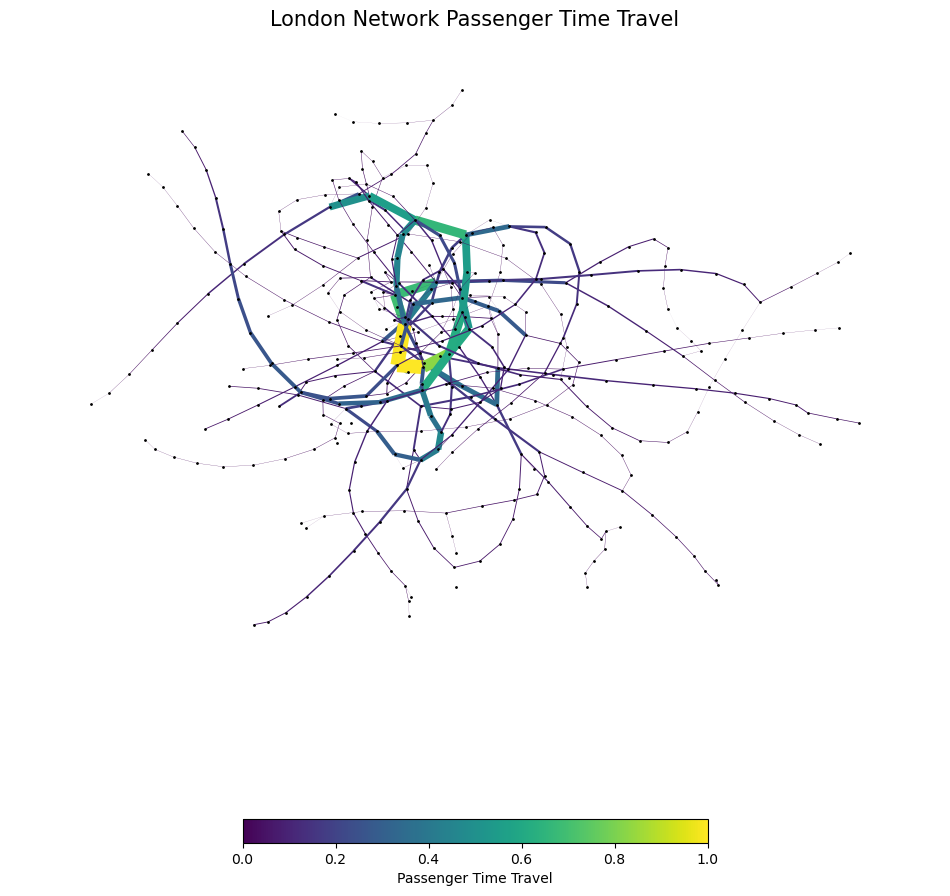

In [87]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'time' attribute exists in edges
max_time = max(data['time'] for u, v, data in G.edges(data=True))
time_color = [(i[2]['time'] / max_time) for i in G.edges(data=True)]
time_width = [(i[2]['time'] / max_time * 10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12, 12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

# Draw nodes
nx.draw_networkx_nodes(G, 
                       pos = pos, 
                       node_color='black', 
                       node_size=1)

# Adding a colorbar for the edge colors
plt.colorbar(edg, label="Passenger Time Travel", orientation="horizontal", shrink=0.5)

plt.axis("off")
plt.title("London Network Passenger Time Travel", fontsize=15)
plt.show()


plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

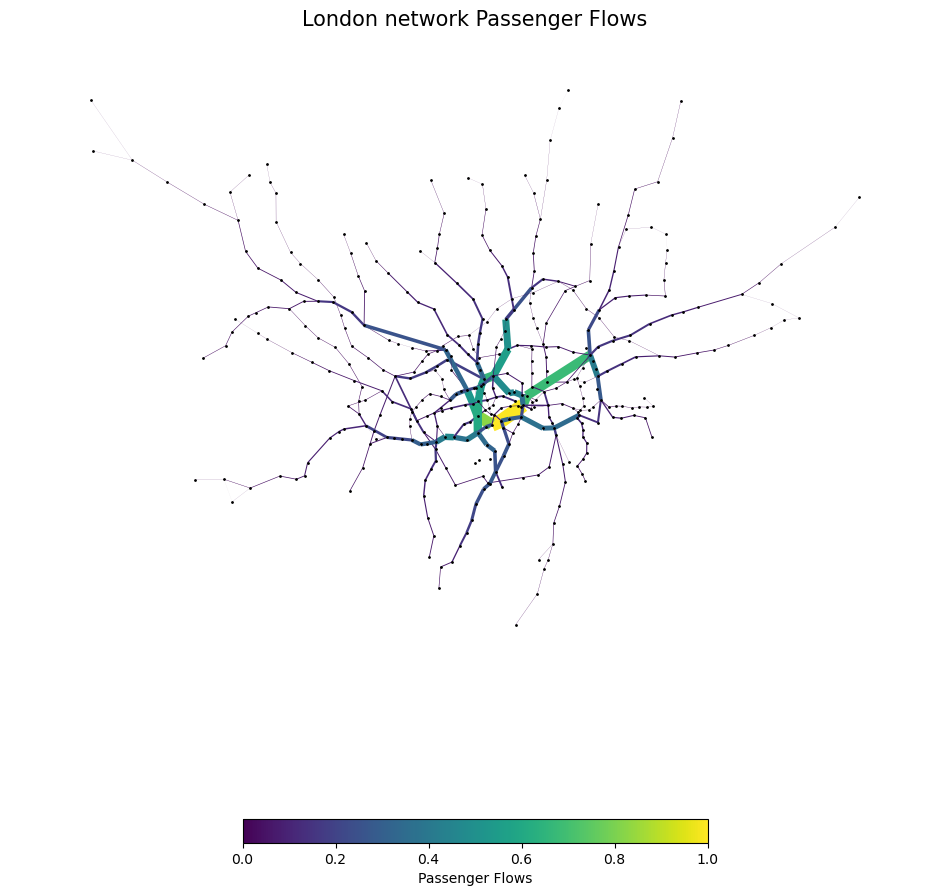

In [73]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [ ]:
# weighted alternatives
## 1. time and flow = weight


# II. Average Shortest Path Length (APL) Analysis

In [ ]:
## a. Scenario 1: Business As Usual

In [ ]:
## b. Scenario 2: Winter Disruption without Government Intervention

In [ ]:
## c. Scenario 3: Winter Disruption with Government Intervention

In [ ]:
## d. APL Comparison between Scenarios

# III. Betweeness Centrality (BC) Analysis

In [ ]:
## a. Scenario 1: Business As Usual

In [ ]:
## b. Scenario 2: Winter Disruption without Government Intervention

In [ ]:
## c. Scenario 3: Winter Disruption with Government Intervention

In [ ]:
## d. BC Comparison between Scenarios

# IV. Intervention Recommendation